# 3.6.4 Housing Prices

Using this Kaggle data, the objective is to create a model to predict a house's value. We want to be able to understand what creates value in a house, as though we were a real estate developer.

__Data Source__: Kaggle Data Set

__Description__: Melbourne is currently experiencing a housing bubble (some experts say it may burst soon). Maybe someone can find a trend or give a prediction? Which suburbs are the best to buy in? Which ones are value for money? Where's the expensive side of town? And more importantly where should I buy a 2 bedroom unit?

Some Key Details

Suburb: Suburb

Address: Address

Rooms: Number of rooms

Price: Price in Australian dollars

Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.

Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

SellerG: Real Estate Agent

Date: Date sold

Distance: Distance from CBD in Kilometres

Regionname: General Region (West, North West, North, North east ...etc)

Propertycount: Number of properties that exist in the suburb.

Bedroom2 : Scraped # of Bedrooms (from different source)

Bathroom: Number of Bathrooms

Car: Number of carspots

Landsize: Land Size in Metres

BuildingArea: Building Size in Metres

YearBuilt: Year the house was built

CouncilArea: Governing council for the area

Lattitude: Self explanitory

Longtitude: Self explanitory

In [1]:
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics

### Data cleaning

In [2]:
df = pd.read_csv('Melbourne_housing_FULL.csv')

In [3]:
print ("Shape of data: ", df.shape)
display(df.head(5))

Shape of data:  (34857, 21)


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


In [4]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64

We are missing values in the following features: Price, Distance, Postcode, Bedroom2, Bathroom, Car, Landsize, BuildingArea, YearBuilt, Lattitude, Longitude, CouncilArea, Regionname, and Propertycount.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [6]:
# Converting date to a date object
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Inspecting data
df.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


From this description we can note that Bathroom, Building Area and Year Built, have values that don't make sense.

In [8]:
#inspecting properties with building areas of zero
print('Number of properties with Building Area of Zero:', df.BuildingArea[df.BuildingArea == 0].count())
print('Number of properties with Zero Bathrooms:', df.Bathroom[df.Bathroom == 0].count())


Number of properties with Building Area of Zero: 76
Number of properties with Zero Bathrooms: 46


In [9]:
# Setting all properties with zero bathrooms to one
df.Bathroom = df.Bathroom.map(lambda x: x if x>0 else 1)

In [10]:
# Setting all properties with Building Area of zero to none
df.BuildingArea = df.BuildingArea.map(lambda x: x if x>0 else None)

In [11]:
# Removing rows with null values in categorical columns
df_to_transf = df.dropna(axis=0,subset=['Regionname', 'CouncilArea', 'Propertycount'])

# Separating into categorical and continuous data
df_cat = df_to_transf[['Suburb', 'Address', 'Type', 'Method', 'SellerG', 
                     'Date', 'Regionname', 'CouncilArea']]
df_cont = df_to_transf.loc[:,~(df.columns.isin(df_cat.columns))]

In [12]:
# Filling missing values with median values
imputer = Imputer(strategy='median')
df_transformed = pd.DataFrame(imputer.fit_transform(df_cont), 
                               columns=[df_cont.columns])

In [13]:
df_transformed.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34854.000000,3.485400e+04,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000,34854.000000
mean,3.031072,1.010863e+06,11.185204,3116.065645,3.064698,1.478711,1.796723,569.005652,145.860201,1967.898462,-37.809940,145.003212,7572.888306
std,0.969943,5.720167e+05,6.788983,109.025570,0.858127,0.684493,0.883005,2764.026645,252.142098,25.043118,0.079293,0.105562,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.010000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.950000e+05,6.400000,3051.000000,3.000000,1.000000,1.000000,357.000000,136.000000,1970.000000,-37.846900,144.964400,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,1.000000,2.000000,521.000000,136.000000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.150000e+06,14.000000,3156.000000,3.000000,2.000000,2.000000,598.000000,136.000000,1970.000000,-37.770893,145.051750,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.000000,2106.000000,-37.390200,145.526350,21650.000000


In [14]:
# Adding back in all of the categorical data

# List of data frames to concatenate and combine

dfs = [df_transformed, df_cat]
df_t = pd.concat(dfs, axis=1)

print(df_t.columns)

# Renaming columns

df_t.columns=(['Rooms', 'Price','Distance','Postcode', 'Bedroom2', 'Bathroom','Car',
                'Landsize','BuildingArea','YearBuilt','Latitude',
                'Longitude','Propertycount','Suburb','Address','Type',
               'Method','SellerG','Date','Regionname','CouncilArea'])
df_t.head()

Index([        ('Rooms',),         ('Price',),      ('Distance',),
            ('Postcode',),      ('Bedroom2',),      ('Bathroom',),
                 ('Car',),      ('Landsize',),  ('BuildingArea',),
           ('YearBuilt',),     ('Lattitude',),    ('Longtitude',),
       ('Propertycount',),           'Suburb',          'Address',
                   'Type',           'Method',          'SellerG',
                   'Date',       'Regionname',      'CouncilArea'],
      dtype='object')


,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,...,Longitude,Propertycount,Suburb,Address,Type,Method,SellerG,Date,Regionname,CouncilArea
0,2.0,870000.0,2.5,3067.0,2.0,1.0,1.0,126.0,136.0,1970.0,...,144.9958,4019.0,Abbotsford,68 Studley St,h,SS,Jellis,2016-03-09,Northern Metropolitan,Yarra City Council
1,2.0,1480000.0,2.5,3067.0,2.0,1.0,1.0,202.0,136.0,1970.0,...,144.9984,4019.0,Abbotsford,85 Turner St,h,S,Biggin,2016-03-12,Northern Metropolitan,Yarra City Council
2,2.0,1035000.0,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,...,144.9934,4019.0,Abbotsford,25 Bloomburg St,h,S,Biggin,2016-04-02,Northern Metropolitan,Yarra City Council
3,3.0,870000.0,2.5,3067.0,3.0,2.0,1.0,0.0,136.0,1970.0,...,145.0116,4019.0,Abbotsford,18/659 Victoria St,u,VB,Rounds,2016-04-02,Northern Metropolitan,Yarra City Council
4,3.0,1465000.0,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,...,144.9944,4019.0,Abbotsford,5 Charles St,h,SP,Biggin,2017-04-03,Northern Metropolitan,Yarra City Council


### Data exploring

Our target variable appears to be normally distributed and skewed to the right. That is, the majority of homes around $900k.

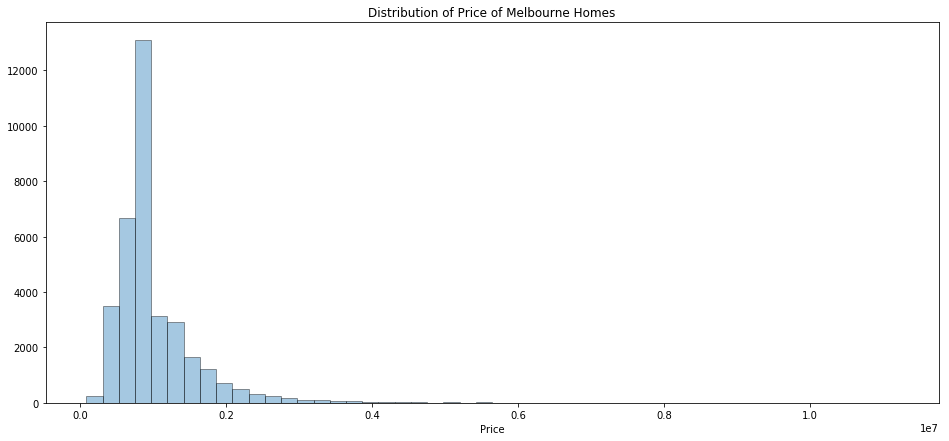

In [15]:
plt.figure(figsize=(16,7))
sns.distplot(df_t['Price'].dropna(), kde = False,hist_kws=dict(edgecolor="k"))
plt.title('Distribution of Price of Melbourne Homes')
plt.show()

#### Categorical Features vs Price

/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


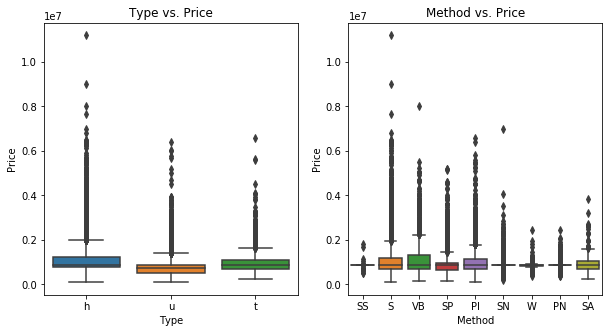

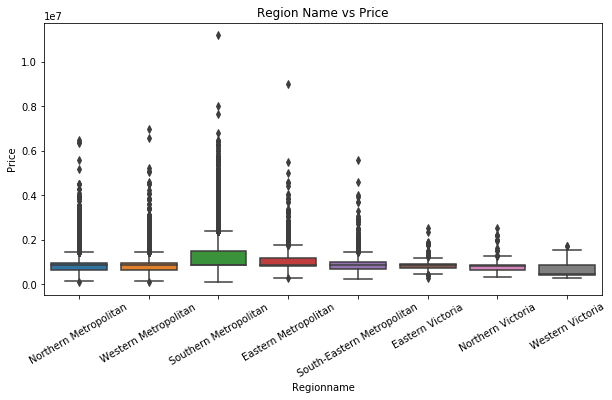

In [16]:
#boxplots of price versus categorical data 
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.boxplot(x='Type', y='Price', data=df_t)
plt.title('Type vs. Price')

plt.subplot(1,2,2)
sns.boxplot(x='Method', y='Price', data=df_t)
plt.title('Method vs. Price')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Regionname', y='Price', data=df_t)
plt.title('Region Name vs Price')
plt.xticks(rotation=30)
plt.show()

- Median prices for houses are over  1M AUD, townhomes are  800k AUD to 900k AUD and units are approx 500k AUD.
- The highest price is gained when a property is sold, not passed in or vendor bid.
- Median prices in the Metropolitan Region are higher than than that of Victoria Region.

#### Numerical Features vs Price

In [17]:
print(df_cont.columns)

Index(['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude',
       'Propertycount'],
      dtype='object')


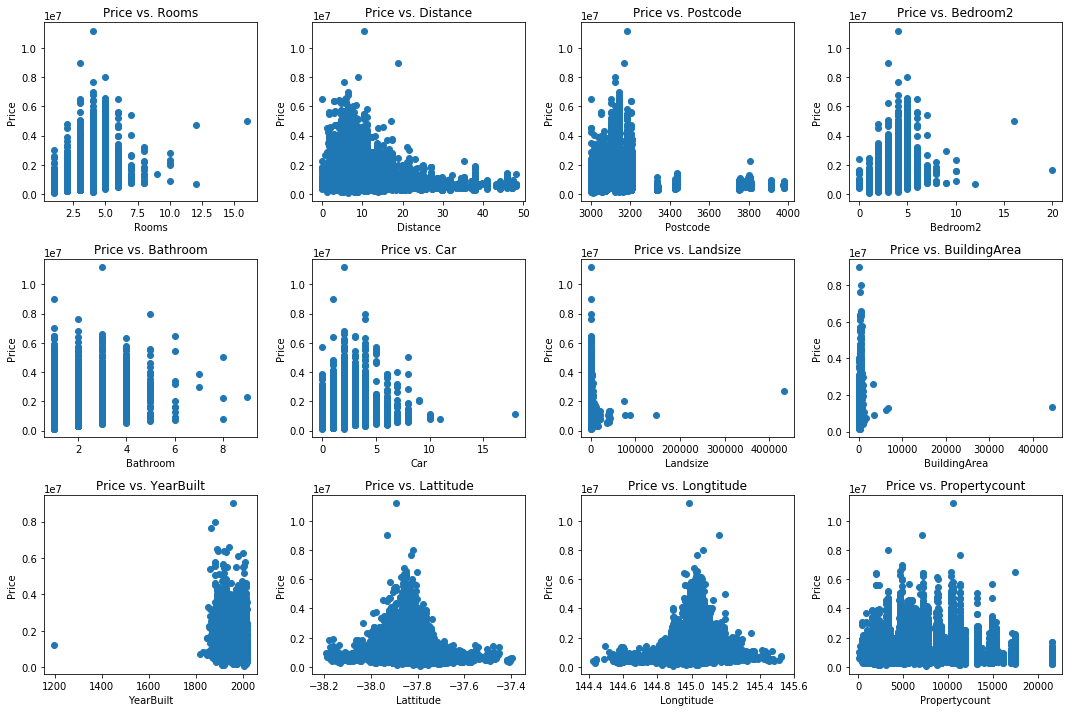

In [18]:
plt.figure(figsize=(15,10))
i=1

for col in df_cont.columns.drop('Price'):
    plt.subplot(3,4,i)
    plt.scatter(x=df_cont[col], y=df_cont['Price'])
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.title('Price vs. {}'.format(col))
    i+=1

plt.tight_layout()
plt.show()

- The majority of homes in the dataset have 4 or 5 rooms.
- The most prominent trend is that there is a negative correlation between Distance from Melbourne's Central Business District (CBD) and Price. The most expensive homes tend to be within 20km of the CBD.

#### Correlation

Text(0.5,1,'Variable Correlation')

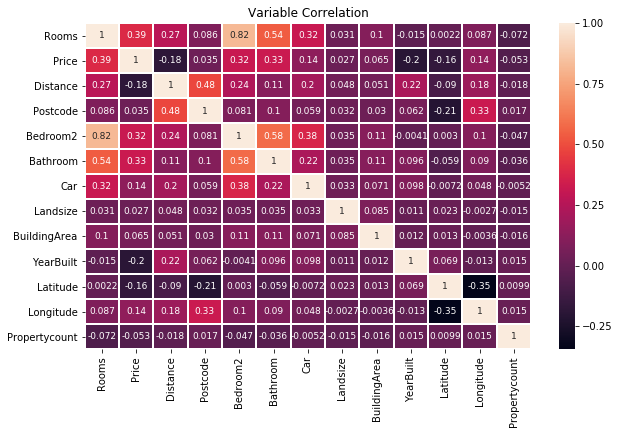

In [19]:
plt.figure(figsize=(10,6))
sns.heatmap(df_t.corr(),linewidth = 1,annot= True, annot_kws={"size": 9})
plt.title('Variable Correlation')

__Weak Positive Correlation__
- Year Built and Price

__Moderate Positive Correlation__
- Rooms and Price
- Bathrooms and Price
- Building Area and Price

### Feature engineering

Another important feature is to determine if a home is historic or not.

In [20]:
# Creating features dataframe with price, rooms, parking, longitude, distance, and landsize
features_i = df_t[['Price', 'Rooms', 'Car', 'Longitude', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']]

# Creating rooms per bathroom feature
features_i['Rooms_per_bathroom'] = df_t['Rooms'] / df_t['Bathroom']

# Creating historic homes feature
features_i['Historic'] = np.where(df_t['YearBuilt'] < (2017-50), 1,0)

features_i = features_i.dropna()

/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# Input and outcome variables
X = features_i.drop('Price', axis=1)
Y = features_i['Price']

## Models

In [22]:
df_eval = pd.DataFrame()
evals = np.zeros(3)

# Holdout: split fraud and non_fraud
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#### Holdout groups

- X_train
- X_test
- Y_train
- Y_test

### Linear Regression

In [23]:
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
print('Coefficients:', linreg.coef_)
print('Intercept:', linreg.intercept_)

Coefficients: [  2.81672577e+05   4.05407248e+04   8.18447061e+05  -2.65600286e+04
   8.05711844e+00   5.16530953e+01  -3.52686601e+03  -6.66978286e+04
  -2.83563167e+04]
Intercept: -111210171.645


In [24]:
scores_lr = cross_val_score(linreg, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lr.mean(), 
                                                                      (scores_lr.std())*2))

Cross Validation Accuracy Scores: 0.225(+/- 0.44)


In [25]:
scores_lrT = cross_val_score(linreg, X_test, Y_test, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_lrT.mean(), 
                                                                      (scores_lrT.std())*2))
print('R-squared for Test Set:', linreg.score(X_test, Y_test))

Cross Validation Accuracy Scores: 0.245(+/- 0.19)
R-squared for Test Set: 0.277176045494


### Random Forest

In [26]:
# RandomForestClassifier 
start = time.time()
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, Y_train)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 10.60


In [27]:
scores_rfr = cross_val_score(rfr, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfr.mean(), 
                                                                      (scores_rfr.std())*2))
print('R-squared for Train Set:', rfr.score(X_test, Y_test))

Cross Validation Accuracy Scores: 0.408(+/- 0.06)
R-squared for Train Set: 0.367046386992


We'll use GridSearCV to optimize our model.

In [29]:
parameters = {'n_estimators':[10,100,500],
             'max_features':['auto', 'sqrt', 'log2'],
             'min_samples_split':[2,8,20],
             'bootstrap':[True, False],
             'max_depth':[4,5,6,7,8]}
t0 = time.time()
grid_rfr = GridSearchCV(rfr, param_grid=parameters, cv=5)
grid_rfr.fit(X_train, Y_train)
print(grid_rfr.best_score_)
print(grid_rfr.best_params_)
t1 = time.time()
print('Model Fit Time:', t1-t0)

0.402186809533
{'bootstrap': True, 'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 100}
Model Fit Time: 6348.169435977936


In [30]:
# Instantiating model with best parameters

best_params_rfr = grid_rfr.best_params_
rfr2 = RandomForestClassifier(**best_params_rfr)
rfr2.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Applying our refined model to the test set

In [31]:
print('R-squared Training Set:', rfr2.score(X_train, Y_train))
print('R-squared Test Set:', rfr2.score(X_test, Y_test))

R-squared Training Set: 0.221425241186
R-squared Test Set: 0.219624157223


In [32]:
grid_rfr.score(X_test, Y_test)

0.37054454352708288

## Evaluation

In [37]:
importances = pd.DataFrame(index=X_train.columns)
importances['Importance'] = rfr2.feature_importances_
importances.sort_values('Importance', ascending=False)

,Importance
Longitude,0.234336
Distance,0.170125
Landsize,0.139054
BuildingArea,0.134808
YearBuilt,0.113105
Rooms,0.091531
Rooms_per_bathroom,0.056781
Car,0.051458
Historic,0.008802


In [38]:
price_fn = pd.DataFrame(index=X_train.columns)
price_fn['Coefficients'] = linreg.coef_
price_fn.sort_values('Coefficients', ascending=False)

,Coefficients
Longitude,818447.061382
Rooms,281672.577026
Car,40540.724786
BuildingArea,51.653095
Landsize,8.057118
YearBuilt,-3526.866009
Distance,-26560.028611
Historic,-28356.316677
Rooms_per_bathroom,-66697.828611


In [41]:
y_pred = linreg.predict(X_test)
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y_test,y_pred)))

RMSE: 480676.16776


## write-up

The aim is to create a model to predict a house's value and we want to be able to understand what creates value in a house. I chose __Linear Regression__ as my model of choice given the results I obtained. It has an accuracy of almos 30%, and a RMSE score that tells us explicitly how much our predictions from the actual value deviated which in this case, it was 480,676.47 AUD.

Using linea regression, the following factors impact the price:

- An increase in longitude increases the price by 818,447 AUD
- An increase in number of rooms increases the price by 281,672 AUD
- An increase in number of parking spaces increases the price by 40,540 AUD
- An increase in building area increases the price by 51 AUD
- An increase in land size increases the price by 8 AUD
- An increase in the year built decreases the price by 3,526 AUD
- An increase in distance from the city center decreases the price by 36,560 AUD
- Becoming a historic home decreases the price by 28,356 AUD
- An increase in number of rooms per bathroom decreases the price by 66,697 AUD